In [1]:
%load_ext autoreload
%autoreload 2

# Config

In [2]:
import os
import numpy as np
import time
import ray
from algorithms.utils import Config, LogClient, LogServer
from algorithms.algorithm import RL

os.environ['RAY_OBJECT_STORE_ALLOW_SLOW_STORAGE']='1'

    
"""
This section contains run args, separated from args for the RL algorithm and agents
"""
args = Config()
#### computation
os.environ['CUDA_VISIBLE_DEVICES']='1'
args.n_thread = 1
args.parallel = False
args.device = 'cpu'
args.n_cpu = 1 # per agent, used only if parallel = True
args.n_gpu = 0

#### general
args.debug = False
args.test = False # if no training, only test
args.profiling = False
backend = 'tensorboard'

#### algorithm and environment
from algorithms.config.SAC import getArgs

import gym
from algorithms.envs.Wrapper import GymWrapper
env_name = 'LunarLander-v2'

args.name='jupyter-visualization'

#### misc
args.save_period=900 # in seconds
args.log_period=int(20)
args.seed = None
args.test_interval = int(3e4)
args.n_test = 10

def env_fn():
    return GymWrapper(env_name, 0, 1)

agent_args = getArgs(8, 4)

algo_args = Config()
algo_args.replay_size=int(1e6)
algo_args.max_ep_len=1000
algo_args.n_step=int(1e8)
#### checkpoint
algo_args.init_checkpoint = 'checkpoints/SAC-Lunar_LunarLander-v2_SAC_16686/21538671_259.63662453068207.pt'
algo_args.start_step = 0

agent_args.gamma=0.99

##########################

env = env_fn()
print(f"observation: {env.env.observation_space}, action: {env.env.action_space}")
del env
algo_args.env_fn = env_fn
args.env_fn = env_fn

algo_args.agent_args = agent_args
p_args, q_args, pi_args = agent_args.p_args, agent_args.q_args, agent_args.pi_args
if args.debug:
    pi_args.update_interval = 1
    q_args.update_interval = 1
    algo_args.batch_size = 4
    algo_args.max_ep_len=2
    algo_args.replay_size=1
    if not p_args is None:
        p_args.model_buffer_size = 4
    algo_args.n_warmup=1
    algo_args.n_test=1
if args.test:
    algo_args.n_warmup = 0
    algo_args.n_test = 10
    algo_args.n_step = 1
if args.profiling:
    algo_args.batch_size=128
    if algo_args.agent_args.p_args is None:
        algo_args.n_step = 50
    else:
        algo_args.n_step = algo_args.batch_size + 10
        algo_args.replay_size = 1000
        algo_args.n_warmup = algo_args.batch_size
    algo_args.n_test = 1
    algo_args.max_ep_len = 20
if args.seed is None:
    args.seed = int(time.time()*1000)%65536

agent_args.parallel = args.parallel
args.name = f'{args.name}_{env_name}_{agent_args.agent.__name__}_{args.seed}'


if not p_args is None:
    print(f"rollout reuse:{(p_args.refresh_interval/q_args.update_interval*algo_args.batch_size)/p_args.model_buffer_size}")
# each generated data will be used so many times

import torch
torch.set_num_threads(args.n_thread)
print(f"n_threads {torch.get_num_threads()}")
print(f"n_gpus {torch.cuda.device_count()}")

ray.init(ignore_reinit_error = True, num_gpus=len(os.environ['CUDA_VISIBLE_DEVICES'].split(',')))
backend = ''
logger = LogServer.remote({'run_args':args, 'algo_args':algo_args}, backend = backend)
logger = LogClient(logger)

observation: Box(-inf, inf, (8,), float32), action: Discrete(4)
n_threads 1
n_gpus 1


2021-08-17 16:27:11,458	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8270
2021-08-17 16:27:11,464	WARNING services.py:1730 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 58970112 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


# Run

In [11]:
rl = RL(logger = logger, run_args=args, **algo_args._toDict())
agent = rl.agent

loaded checkpoints/SAC-Lunar_LunarLander-v2_SAC_16686/21538671_259.63662453068207.pt


In [16]:
rl.test()

100%|████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.87it/s]

jupyter-visualization_LunarLander-v2_SAC_8696
[269.40733965 257.99874458 271.34513462 254.21914198 275.60869609
 287.46198793 246.10683478 230.09543459  13.50881856 267.62237039]
10 episodes average accumulated reward: 237.33745031748003
scaled reward 237.33745031748003


237.33745031748003

# Virtual Desktop

In [17]:
import matplotlib.pyplot as plt
from numpy import random
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Visualization

282.49943385798315


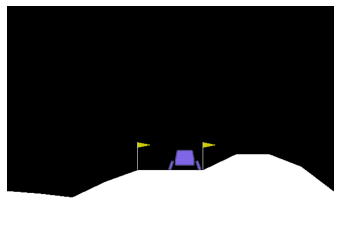

In [22]:
# Load the gym environment

import gym
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('LunarLander-v2')
env.seed(23)

# Let's watch how an untrained agent moves around
rewards = []
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(1000):
    action = agent.act(state.reshape(1, -1))
    #action = random.choice(range(4))
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if isinstance(action, torch.Tensor):
        action = action.numpy()[0]
    state, reward, done, _ = env.step(action[0])
    rewards.append(reward)
    if done:
        break 
print(sum(rewards))
        
env.close()

## Human Control

In [ ]:
# Load the gym environment

import gym
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('LunarLander-v2')
env.seed(23)

# Let's watch how an untrained agent moves around

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
last = '0'
for j in range(200):
#     action = agent.act(state)
    tmp = input()
    if len(tmp) == 0:
        tmp = last
    else:
        last = tmp
    action = int(tmp)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()